# BurstMyBubble (BMB) exploration of training data

The data used here can be found in [convote](http://www.cs.cornell.edu/home/llee/data/convote.html) from Cornell university. For the purpose of this app, we used the stage_one set in convote:

>"data_stage_one" was used to identify by-name references to
  train our agreement classifier, which acts on such references.  All
  references in this dataset are annotated with a special set of
  characters of the form "xz1111111", where 1111111 is replaced by a
  seven-digit code indicating the House Member who we determined to be
  the target of the reference.  The first six digits of the code
  matches the index used to label the target Member's speech segments,
  (see description of our individual-file-naming convention, below).  The
  seventh digit is a relic from early experiments and was not used in
  our final study.
  
This notebook will explore the development set to test the implementation of **BMB**. For this notebook to work you will have to untar `tar -xzvf convote_v1.1.tar.gz` in the data folder.

In [1]:
%matplotlib inline
import os
import nltk
import numpy as np
import pandas as pd
from glob import glob
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from collections import ChainMap, defaultdict

output_notebook()
plt.style.use('ggplot')
stop_words= stopwords.words("english")
data_path = '../data/convote_v1.1/data_stage_two/development_set'
files = glob(os.path.join(data_path, '*.txt'))
tokenizer = RegexpTokenizer(r'\w+')
lemmatize = WordNetLemmatizer()
sent_tokenize


def frequency_explorer(tokens, title):
    """
    This function tokenize it and plots the frequency of a text string
    """
    tokens = [lemmatize.lemmatize(x) for x in tokens]
    fdist = FreqDist(tokens)
    print(fdist)
    print(title)
    fdist.plot(30,cumulative=False)
    plt.show()

    
def opennfilter(filename):
    """
    Reads a file, tokenize it, filter stopwords, and returns a list of strings of cleaned text
    """
    # get label based on the filename structure ###_@@@@@@_%%%%$$$_PMV.txt, where p is the party
    parts = os.path.basename(filename[:filename.rfind('.txt')]).split('_')
    info = dict(
    party = parts[-1][0],
    votet = parts[-1][-1],
    billn = parts[1],
    speaker = parts[2]
    )
    with open(filename) as text:
        tokens = tokenizer.tokenize(text.read())
        tokens = [lemmatize.lemmatize(x) for x in tokens]
        filtered_sent = ' '.join([w for w in words if w not in stop_words])
    return info['party'], filtered_sent, info


def read_files(files):
    """
    Reads a file, tokenize it, filter stopwords, and returns a list of strings of cleaned text
    """
    parties = []
    sentences = []
    info = []
    for filename in files:
        # get label based on the filename structure ###_@@@@@@_%%%%$$$_PMV.txt, where p is the party
        parts = os.path.basename(filename[:filename.rfind('.txt')]).split('_')
        info.append(dict(
        party = parts[-1][0],
        votet = parts[-1][-1],
        billn = parts[1],
        speaker = parts[2]
        ))
        parties.append(parts[-1][0])
        with open(filename) as text:
            sentences.append(text.read())
    return parties, sentences, info

def pca(dataframe, **kwargs):
    print('Data has %d rows and %d columns' %(dataframe.shape[0], dataframe.shape[0]))
    pca = PCA(n_components=2)
    return pca.fit_transform(dataframe)


def lda(dataframe, labels):
    print('Data has %d rows and %d columns' %(dataframe.shape[0], dataframe.shape[1]))
    lda = LDA(n_components=None)
    return lda.fit_transform(dataframe, y=labels)


def pca_plot(X_pca, labels):
    """
    Creates a PCA from dataframe, and plots it coloring based on labels
    """
    colors = ['navy', 'crimson']
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, ['D', 'R'], labels):
            plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, lw=1, label=target_name)
    plt.show()            

    
def pca_bokeh_plot(t_pca, lables, **kwargs):
    """
    Compute BOG, perform pca or lda according to function (fnc) and plot with bokeh
    """
    colors = ['crimson' if x == 'R' else 'navy' for x in labels]
    if t_pca.shape[1] == 1: 
        d = dict(x=range(t_pca.shape[0]), y=t_pca[:, 0])
        xlabel = 'Document Index'
        ylabel = 'Dimension 1'
    else:
        d = dict(x=t_pca[:, 0], y=t_pca[:, 1])
        xlabel = 'Dimension 1'
        ylabel = 'Dimension 2'
    d.update(kwargs)
    d['colors'] = colors
    source = ColumnDataSource(data=d)
    TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    p = figure(plot_width=600, plot_height=300, tools=TOOLS)
    p.scatter('x', 'y', source=source, radius=1.5, fill_color='colors', fill_alpha=0.6, line_color=None)
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    #p.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[cr], mode='hline'))
    show(p)
    
def createBOW(document, ngram):
    """
    Compute BOW with given ngram range
    """
    cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = ngram, tokenizer = tokenizer.tokenize)
    text_counts= cv.fit_transform(document)
    return pd.DataFrame(text_counts.toarray())
    
def plot_ngrams(dataframe, fnc, **kwargs):
    """
    Perform pca or lda according to function (fnc) and plot with matplotlib
    """
    df = dataframe
    print('Shape before dimensionality reduction', df.shape)
    df = df.loc[:,~df.columns.duplicated()]
    print('Shape after deduplication', df.shape)
    t_pca = fnc(df, labels=kwargs['party'])
    print('Shape of reduced data', t_pca.shape)
    pca_bokeh_plot(t_pca, labels, **kwargs)

Loading BokehJS ...

<FreqDist with 98 samples and 168 outcomes>
Words from ../data/convote_v1.1/data_stage_two/development_set/493_400036_2346028_ROY.txt


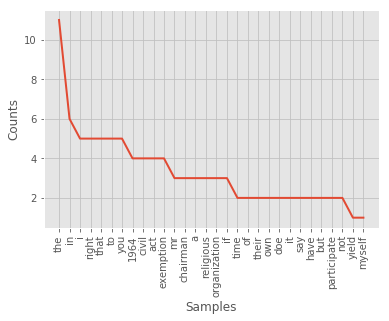

In [2]:
text = open(files[0]).read()
words = tokenizer.tokenize(text)
frequency_explorer(words, 'Words from %s' % files[0])

<FreqDist with 47 samples and 65 outcomes>
Words from ../data/convote_v1.1/data_stage_two/development_set/493_400133_2346116_DON.txt


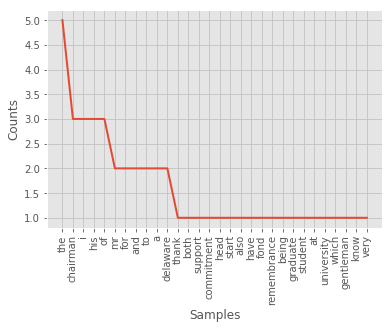

In [3]:
text = open(files[3]).read()
words = tokenizer.tokenize(text)
frequency_explorer(words, 'Words from %s' % files[3])

<FreqDist with 29 samples and 33 outcomes>
Filtered Words from ../data/convote_v1.1/data_stage_two/development_set/493_400133_2346116_DON.txt


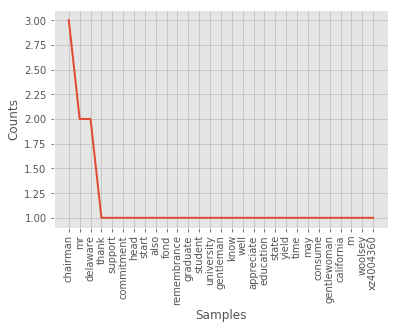

In [4]:
text = open(files[3]).read()
words = tokenizer.tokenize(text)
filtered_sent3 = [w for w in words if w not in stop_words]
frequency_explorer(filtered_sent3, 'Filtered Words from %s' % files[3])

<FreqDist with 58 samples and 85 outcomes>
Filtered Words from ../data/convote_v1.1/data_stage_two/development_set/493_400036_2346028_ROY.txt


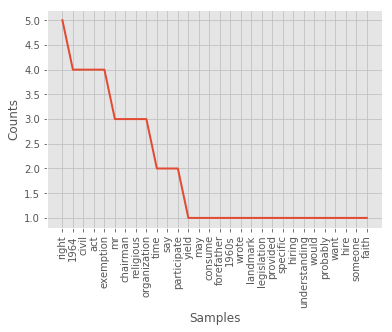

In [5]:
text = open(files[0]).read()
words = tokenizer.tokenize(text)
filtered_sent0 = [w for w in words if w not in stop_words]
frequency_explorer(filtered_sent0, 'Filtered Words from %s' % files[0])

In [6]:
docs = [(filename[:filename.rfind('.txt')].split('_')[-1][0], open(filename).read().strip()) for filename in files]
labels, sentences = zip(*docs)
labels = np.array(labels)
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (5,10), tokenizer = tokenizer.tokenize)
text_counts= cv.fit_transform(sentences)
df1 = pd.DataFrame(text_counts.toarray())

In [8]:
# docs = [opennfilter(filename) for filename in files]
infos = defaultdict(list)
labels, sentences, info = read_files(files)
for dictionary in info:
    for k, v in dictionary.items():
        infos[k].append(v)
data = createBOW(sentences, (1,5))

In [9]:
plot_ngrams(data, lda, **infos)

Shape before dimensionality reduction (418, 107837)
Shape after deduplication (418, 107837)
Data has 418 rows and 107837 columns


/usr/local/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Shape of reduced data (418, 1)


In [10]:
plot_ngrams(data, pca, **infos)

Shape before dimensionality reduction (418, 107837)
Shape after deduplication (418, 107837)
Data has 418 rows and 418 columns
Shape of reduced data (418, 2)
